## Utilizing XP spectra from Gaia: <u>Internal and External Spectra</u>

#### Introduction
BP and RP spectra are read out of the CCDs with 60 wavelength samples (or "bands": they can be thought of as narrow overlapping filters). BP spans 330 - 680 nm with a resolution ($\lambda/ \Delta \lambda$) varying from 85 to 13, RP spans 640-1050 with a resolution of 26 to 17. The resolution is considerably lower than what one would like for AP estimation, but limiations are set by numerous factors. 
The mean BP/RP (also XP) spectra are built on basis functions (Gauss-Hermite)
$$
s(p)= \sum_{i=1}^55 c_ib_i(p)
$$
$$
\vec{s}= D \cdot \vec{c}
$$

where $\vec{s}$ is the XP spectum, $D$ the design matrix and $\vec{c}$ XP coefficients. To the epoch spectra a least-squares fit is applied: $c + Cov(c)$, which is published in GDR3. The mean spectra are available from the archive as an array of coefficients to be applied to a set of basis functions, depending on the set of bases in use, it is possible to represent both internally and externally calibrated spectra using the same array of coefficients (and corellation matrix). For most cases, it is convenient to sample the continuously defined spectra on a grid of positions. These will be pseudo-wavelengths in the case of internally calibrated spectra, and absolute wavelengths in the case of externally calibrated spectra.
**GaiaXP** is a python package that helps computing "sampled XP spectra" from coefficients (ex: flux vs pixels from given wavelengths. It has also a feature that allows to compute integrated photometry in bands and can simulate XP model spectra from SEDs. 

- **Internal System**: describes response function of the instrumentm internally calibrated spectra have units of electrons per second per pixel sample
- **External/ Absolute System** is the commonly used reference system, spectrum defined in units of W $nm^{-1}m^{-2}$ on a scale of absolute wavelenths

In [ ]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
cmap = matplotlib.pyplot.get_cmap('coolwarm')

from gaiaxpy import calibrate
from gaiaxpy import convert

In [5]:
aPer = pd.read_csv('../data/aPer.csv')
IDs_aPer = aPer['GaiaDR2'].to_list()
IDs_aPer = IDs_aPer[::int(len(IDs_aPer)/20)] # just for demo purposes, only keep 20
IDs_aPer

[441416161501150848,
 433169274532974848,
 436786667790598528,
 441780168569668864,
 432459741638340224,
 250552144192052480,
 441515083189174784,
 442736674964779648,
 441650563636259968,
 442269794840563584,
 249812756982996992,
 435289613991362304,
 442601194515899264,
 248246708826521984,
 439669518559926016,
 249368141968881152,
 441746496025526144,
 441363140123581184,
 249010457091505280,
 435410388470374784,
 442008209852822400]

#### Query: 
You can use a simple gaia query or alternatively feed in just the source IDs 
 ```python
query_input = """select TOP 100 source_id from gaiadr3.gaia_source 
WHERE ( 1=CONTAINS(POINT('ICRS',ra,dec),CIRCLE('ICRS',189.9,-60.65,0.2)) ) and has_xp_continuous = 't'"""
calibrated_spectra, sampling = calibrate(query_input)
```
#### Utilities
``calibrate()`` can take a query string or a list of source IDs (str or long). 

Returns: **coeff $\rightarrow$ absolute spec**
- calibrated spectra which is a pandas DataFrame
- sampling passed to the function which is a NumPy array. If no sampling is given the default sampling is returned, it is generated internally and corresponds to ``numpy.arange(336.0,  1021.0, 2.0)`` in absolute wavelengths [nm].

``convert()`` can take a query string or a list of source IDs (str or long). Converts the input internally calibrated mean spectra from the continuous respresentation to a sampled form. 

Returns: **coeff $\rightarrow$ absolute spec**
- values for all sampled spectra as a pandas DataFrame.
- sampling used to convert the input spectra in pseudo-wavelength. This sampling should be an iterable (e.g. a NumPy array), the minimum accepted value is -10 and the maximum is 70. The default sampling is numpy.linspace(0, 60, 600).



In [ ]:
def fetch_external_spectra(IDs):
    # Fetches the spectra from the archive based on the source IDs of the member sources 
    print(f'Queried for N = {len(IDs)}')
    
    calibrated_spectra, sampling = calibrate(IDs,
                                             #output_path = 'outputs/',
                                             #output_format='csv',
                                             save_file= False,
                                             )
    print('Found N spectra:', len(calibrated_spectra))

    # merge dataframes 
    df_spectra = pd.merge(calibrated_spectra, aPer.loc[aPer['GaiaDR2'].isin(IDs_aPer)], how = 'left', left_on='source_id', right_on='GaiaDR2')
    return df_spectra, sampling 

def fetch_internal_spectra(IDs):
    # Fetches the spectra from the archive based on the source IDs of the member sources 
    print(f'Queried for N spectra: {len(IDs)}')

    calibrated_spectra, sampling = convert(IDs,
                                           #output_path = 'outputs/',
                                           #output_format='csv',
                                           save_file= False
                                           )

    print('Found N =: ', len(calibrated_spectra))

    # merge dataframes
    df_spectra = pd.merge(calibrated_spectra, aPer.loc[aPer['GaiaDR2'].isin(IDs_aPer)], how = 'left', left_on='source_id', right_on='GaiaDR2')
    return df_spectra, sampling 

In [61]:
%%time 

Pismis3_external, sampling_external = fetch_external_spectra(IDs_aPer)

Pismis3_internal, sampling_internal = fetch_internal_spectra(IDs_aPer)

Queried for N = 21
Found N spectra: 20                                       /20 [00:00<?, ?spec/s]
Queried for N spectra: 21
Found N =:  40                                           /20 [00:00<?, ?spec/s]
CPU times: user 386 ms, sys: 33.2 ms, total: 419 ms
Wall time: 2.51 s


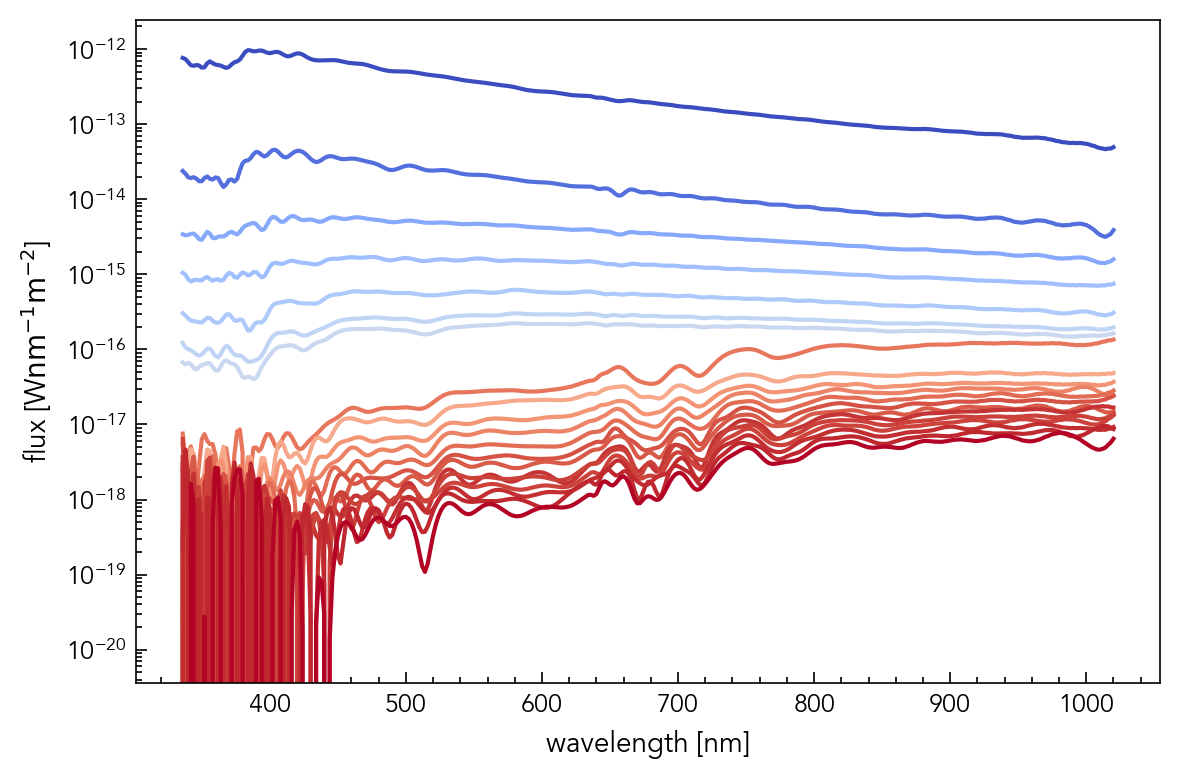

In [ ]:
norm = colors.Normalize(vmin = Pismis3_external['BP-RP'].min(), vmax = Pismis3_external['BP-RP'].max())
#cmap = cmap(norm(colorToPlot))

for i in range(len(Pismis3_external)):
    plt.plot(sampling_external, Pismis3_external['flux'].iloc[i], alpha=1.,
             color = cmap(norm(Pismis3_external['BP-RP'].iloc[i])))

plt.xlabel('wavelength [nm]')
plt.ylabel('flux [W$nm^{-1}m^{-2}$]')
plt.yscale('log')

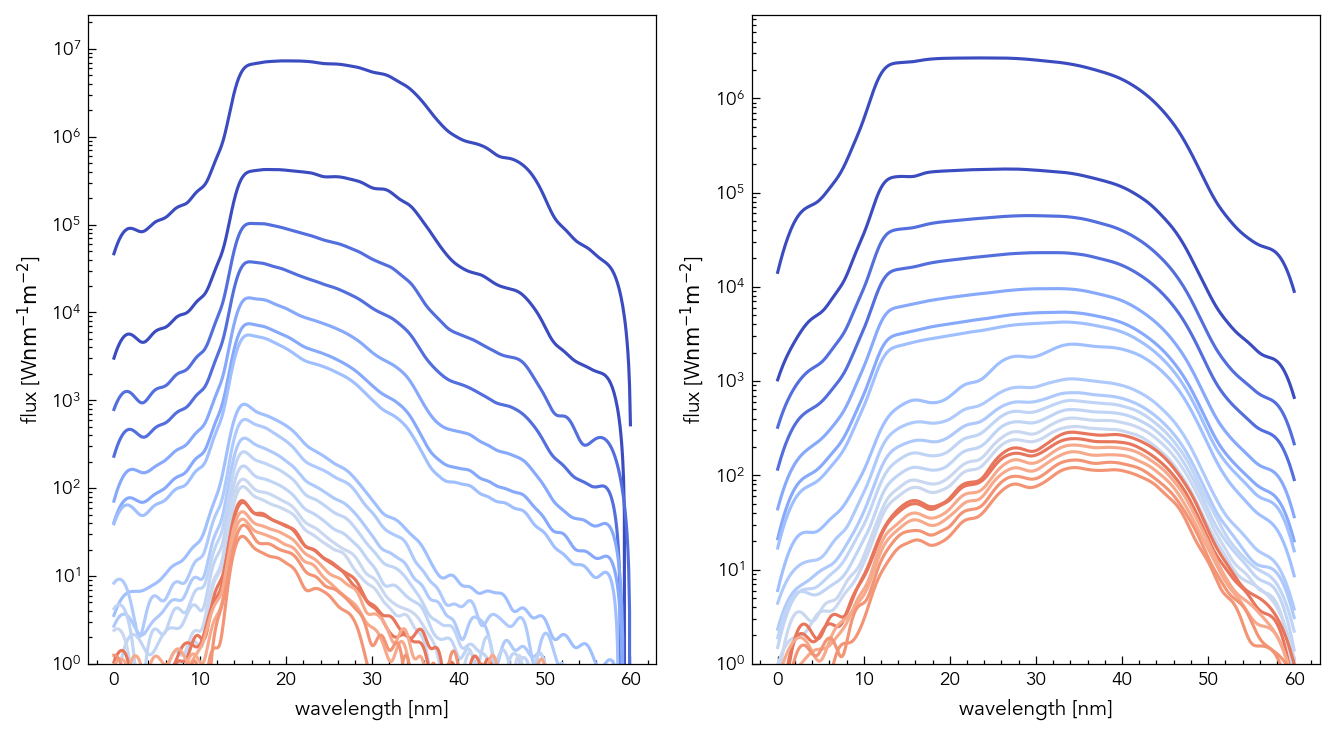

In [ ]:
df_BP = Pismis3_internal.loc[Pismis3_internal['xp'] == 'BP']
df_RP = Pismis3_internal.loc[Pismis3_internal['xp'] == 'RP']

vmin = Pismis3_internal['BP-RP'].min()
vmax = Pismis3_internal['BP-RP'].max()
norm = colors.Normalize(vmin=vmin, vmax=vmax)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5), dpi=150)

for i in range(len(df_BP)):
    colorToPlot = Pismis3_internal['BP-RP'].iloc[i]
    ax1.plot(sampling_internal, df_BP['flux'].iloc[i], color=cmap(norm(colorToPlot)))
    ax2.plot(sampling_internal, df_RP['flux'].iloc[i], color=cmap(norm(colorToPlot)))

for ax in (ax1, ax2):
    ax.set_yscale('log')
    ax.set_xlabel('wavelength [nm]')
    ax.set_ylabel('flux [W$nm^{-1}m^{-2}$]')
    ax.set_ylim(1e0)

